### Práctica realizada por Pablo Torre e Ignacio Jiménez

After some testing, our final approach was the following:

We will first fine-tune a BERT model using all three datasets. Then, we will use that model to train classification heads on top of it, one for each difficulty. For both steps, we will employ a siamese approach by passing each text independently through the model and then comparing the embeddings of the [CLS] token that BERT outputs.

To fine-tune BERT, our goal is to increase both the Euclidean distance and decrease cosine similarity between texts from different authors while doing the opposite for texts from the same author. We hope that this approach will teach the model to prioritize writing style over topic.

Once the fine-tuning process is complete, we proceed to freeze the model and train a classification head on top of it for each dataset.

We will be using the F1 score macro to analyse the performance of the models, since not all datasets are equally balanced.

All this work was performed using an AMD Radeon Rx 6600xt with 8gb of VRAM

# Imports

In [1]:
import torch
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import LongformerModel, LongformerTokenizer
from transformers import RobertaTokenizer, RobertaModel, DistilBertTokenizer, DistilBertModel
from torch import cuda
import pandas as pd
import numpy as np
import glob
import os
import json
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.cuda.amp import autocast

2023-12-01 12:51:18.098962: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-01 12:51:18.273312: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 12:51:18.273337: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 12:51:18.273856: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 12:51:18.342200: I tensorflow/core/platform/cpu_feature_g

In [2]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


# Dataset

We will define our dataset and perform some data augmentation. We create more text-pairs by adding to our dataset all the combinations of texts from the same author (more 0s) and texts of one author with the next one (more 1s).

In [3]:
# Our dataset
class ADataset(Dataset):
    def __init__(self, difficulty, type):
        self.type = type
        self.difficulty = difficulty

        # we load the dataset from the file system
        route = 'pan23-multi-author-analysis-dataset'
        # we load all the three difficulties for the fine-tuning
        if difficulty == 'all':
            self.dataset = pd.concat([ADataset('easy', type).dataset, ADataset('medium', type).dataset, ADataset('hard', type).dataset], ignore_index=True)
            return
        elif difficulty == 'easy':
            num = '1'
        elif difficulty == 'medium':
            num = '2'
        elif difficulty == 'hard':
            num = '3'
        path = route + num + '/' + route + num + '-' + self.type + '/'
        problem = []
        sol = []
        num_files = len(glob.glob(os.path.join(path, '*.txt')))

        for i in range(1, num_files + 1):
            with open(path + 'truth-problem-' + str(i) + '.json', "r", newline="") as f:
                v = json.load(f)['changes']
            with open(path + 'problem-' + str(i) + '.txt', "r", newline="") as f:
                s = f.read().split('\n')
                # we leave the dataset unchanged for the test and validation
                if self.type == 'test' or self.type == 'validation':
                    for j in range(len(s) - 1):
                        problem.append(s[j] + '\n' + s[j+1])
                        sol.append(v[j])
                # we augment the dataset for the training
                if self.type == 'train':
                    # we create a dictionary with the authors and the texts they wrote
                    dic = {'author1': [s[0]]}
                    for j in range(len(s) - 1):
                        if(v[j] == 0):
                            dic['author' + str(len(dic))].append(s[j+1])
                        else:
                            dic['author' + str(len(dic)+1)] = [s[j+1]]
                    # combine all elements in the same author
                    for a in dic:
                        for i, t1 in enumerate(dic[a], 0):
                            for i2 in range(i + 1, len(dic[a])):
                                    problem.append(t1 + '\n' + dic[a][i2])
                                    sol.append(0)
                    # combine the elements of one author with the elements of the next author
                    for i, a in enumerate(dic, 0):
                        if i == len(dic) - 1:
                            break
                        a2 = dic['author' + str(i+2)]
                        for t1 in dic[a]:
                            for t2 in a2:
                                problem.append(t1 + '\n' + t2)
                                sol.append(1)

        self.dataset = pd.DataFrame({'text': problem, 'label': sol}, index=range(0, len(problem)))

    def __len__(self):            
        return len(self.dataset)

    def __getitem__(self, index):
        texts = self.dataset.loc[index]['text'].split('\n')
        text1, text2 = texts[0], texts[1]
        return {
            'text1' : text1,
            'text2' : text2, 
            'target': self.dataset.loc[index]['label']}

In [4]:
# returns the appropriate tokenizer for each of the models tested
def get_tokenizer(model_name):
  if model_name == 'roberta-base':
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
  elif model_name == 'allenai/longformer-base-4096':
    tokenizer = LongformerTokenizer.from_pretrained(model_name)
  elif model_name == 'distilbert-base-uncased':
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
  return tokenizer

In [5]:
# returns the appropriate bert for each of the models tested
def get_bert(model_name, difficulty, load_model=False):
    print('Loading model...')
    if model_name == 'roberta-base':
        bert = RobertaModel.from_pretrained(model_name)
    elif model_name == 'allenai/longformer-base-4096':
        bert = LongformerModel.from_pretrained(model_name)
    elif model_name == 'distilbert-base-uncased':
        bert = DistilBertModel.from_pretrained(model_name)
    # loads the fine-tuned model if necessary
    if load_model:
        state_dict = torch.load('pre_{0}_{1}.pt'.format(model_name, difficulty))
        bert.load_state_dict(state_dict)  # Load the state dict into the instance
        print('Fine-tuned model loaded')
    return bert

In [6]:
# to tokenize the texts, pad, get the attention mask and return the tensors
class DataCollator:
    def __init__(self, tokenizer, max_len):
      self.tokenizer = tokenizer
      self.max_len = max_len
      
    def __call__(self, input_batch):
      texts1 = [d['text1'] for d in input_batch]
      texts2 = [d['text2'] for d in input_batch]
      targets = [d['target'] for d in input_batch]

      # dinamic padding for faster compute and less memory usage when possible
      enc1 = self.tokenizer(texts1, return_tensors='pt', truncation=True, padding='longest', max_length=self.max_len)
      enc2 = self.tokenizer(texts2, return_tensors='pt', truncation=True, padding='longest', max_length=self.max_len)

      Y1 = enc1['input_ids']
      Y2 = enc2['input_ids']
      atm1 = enc1['attention_mask']
      atm2 = enc2['attention_mask']

      return Y1, Y2, atm1, atm2, torch.tensor(targets, dtype=torch.float)

In [7]:
# prints some useful information about the dataset
def info_dataset(dataset, tokenizer):
    count = 0
    for i in range(len(dataset)):
        count += dataset.dataset.loc[i]['label']

    max_tokens = 0
    for i in range(len(dataset)):
        texts = dataset.dataset.loc[i]['text'].split('\n')
        text1, text2 = texts[0], texts[1]
        enc1 = tokenizer(text1, truncation=False)
        enc2 = tokenizer(text2, truncation=True)
        if len(enc1['input_ids']) > max_tokens:
            max_tokens = len(enc1['input_ids'])
        if len(enc2['input_ids']) > max_tokens:
            max_tokens = len(enc2['input_ids'])

    print('Dataset: {}'.format(dataset.type))
    print('Number of samples: {}'.format(len(dataset)))
    print('Proportion of 1s and 0s: {} to {}'.format(count/len(dataset), (len(dataset)-count)/len(dataset)))
    print('Maximum sequence lenght of dataset: {}'.format(max_tokens)) 

# Training Functions

We define the training and evaluation functions that will be used for both the fine-tune of the BERT and the training of the classifier heads.

In [8]:
# performs a single training step
def train_step(input_batch, i, model, loss_fn, optimizer, super_batch_size):
    loss = None

    ids1, ids2, atm1, atm2, targets = input_batch
    ids1 = ids1.to(device)
    ids2 = ids2.to(device)
    atm1 = atm1.to(device)
    atm2 = atm2.to(device)
    targets = targets.to(device)
    
    # we use mixed precision to speed up the training
    with autocast():
        outputs = model(ids1, ids2, atm1, atm2)
    loss = loss_fn(outputs.squeeze(), targets)
    
    # backpropagate the loss
    loss.backward()

    # update the weights only every super_batch_size iterations to simulate a bigger batch size
    if i % super_batch_size == super_batch_size - 1:
        # cap gradient for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

    # calculate the f1 score, we apply a sigmoid to the output if the loss function is BCEWithLogitsLoss
    if loss_fn.__class__.__name__ == 'BCEWithLogitsLoss':
        outputs = torch.sigmoid(outputs)
    f1 = f1_score(targets.cpu().detach().numpy(), (outputs.cpu().detach().numpy() > 0.5).astype(int), average='macro')

    return loss.item(), f1


In [9]:
# performs a single validation step
def valid_step(input_batch, model):
    with torch.no_grad():
        ids1, ids2, atm1, atm2, targets = input_batch
        ids1 = ids1.to(device)
        ids2 = ids2.to(device)
        atm1 = atm1.to(device)
        atm2 = atm2.to(device)
        targets = targets.to(device)
        with autocast():
            outputs = model(ids1, ids2, atm1, atm2)
    return outputs, targets

In [10]:
# plots the training and validation loss and f1 score
def print_progress(epoch, i, tracking, num_total_batches):
    clear_output(wait=True)
    print('Epoch: ' + str(epoch))
    print('Batch: ' + str(i) + '/' + str(num_total_batches))

    loss, f1 = np.array(tracking['loss_train']), np.array(tracking['f1_train'])
    if len(loss) > 0:
        # smooth the loss and f1 with a moving average
        ma_size = loss.shape[0] // 5
        last_loss, last_f1 = loss[-1], f1[-1]
        loss = np.convolve(loss, np.ones((ma_size,))/ma_size, mode='valid')
        f1 = np.convolve(f1, np.ones((ma_size,))/ma_size, mode='valid')

        # plot the loss and f1 for the training
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 3, 1)
        plt.title('Training Loss: ' + format(last_loss, '.3f'))
        plt.plot(loss, label='Loss')
        plt.subplot(1, 3, 2)
        plt.title('Training Log Loss: ' + format(np.log(last_loss), '.3f'))
        plt.plot(np.log(loss), label='Log Loss')
        plt.subplot(1, 3, 3)
        plt.title('Training F1 Score: ' + format(last_f1, '.3f'))
        plt.plot(f1, label='F1 Score')
        plt.show()

    # plot the loss and f1 for the validation
    loss, f1 = np.array(tracking['loss_eval']), np.array(tracking['f1_eval'])
    if len(loss) > 0:
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 3, 1)
        plt.title('Evaluation Loss: ' + format(loss[-1], '.3f'))
        plt.plot(loss, label='Loss')
        plt.subplot(1, 3, 2)
        plt.title('Evaluation Log Loss: ' + format(np.log(loss[-1]), '.3f'))
        plt.plot(np.log(loss), label='Log Loss')
        plt.subplot(1, 3, 3)
        plt.title('Evaluation F1 Score: ' + format(f1[-1], '.3f'))
        plt.plot(f1, label='F1 Score')
        plt.show()

In [11]:
# evaluates the model on the validation set and saves the model if it is the best one yet
def valid_epoch(epoch, tracking, eval_loader, model, loss_fn, model_name, difficulty, pre, save=True):
    model.eval()
    outputs = []
    targets = []

    # get the predictions and the targets for the validation set
    for _, data in enumerate(eval_loader, 0):
        out, target = valid_step(data, model)
        outputs.append(out)
        targets.append(target)

    # Convert lists of tensors to tensors
    outputs = torch.cat(outputs)
    targets = torch.cat(targets)
    loss = loss_fn(outputs.squeeze(), targets.to(device))

    # calculate the f1 score, we apply a sigmoid to the output if the loss function is BCEWithLogitsLoss
    if loss_fn.__class__.__name__ == 'BCEWithLogitsLoss':
        outputs = torch.sigmoid(outputs)
    outputs = outputs.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    f1 = f1_score(targets, (outputs > 0.5).astype(int), average='macro')

    # save the results and show the progress
    loss_eval = tracking['loss_eval']
    f1_eval = tracking['f1_eval']
    loss_eval.append(loss.item()), f1_eval.append(f1)
    print_progress(epoch, 1, tracking, 1)

    # save the model if it is the best one, return True if it is not to stop the training
    if save and loss_eval[-1] == min(loss_eval):
        if pre == False: # for the final model
            torch.save(model.state_dict(), '{0}_{1}.pt'.format(model_name, difficulty))
        elif pre == True: # for the fine-tuned model
            torch.save(model.bert.state_dict(), 'pre_{0}_{1}.pt'.format(model_name, difficulty))
        return False
    return True

In [12]:
# trains the model for one epoch
def train_epoch(epoch, tracking, train_loader, eval_loader, model, loss_fn, optimizer, model_name, difficulty, pre, visualization_step=10, super_batch_size=1, eval_interval=100):
    model.train()
    l = tracking['loss_train']
    f1_score = tracking['f1_train']
    for i, data in enumerate(train_loader, 0):
        # perform a training step
        loss, f1 = train_step(data, i, model, loss_fn, optimizer, super_batch_size)
        l.append(loss), f1_score.append(f1)
        # show the progress every visualization_step batches
        if i % visualization_step == visualization_step - 1:
            print_progress(epoch, i, tracking, len(train_loader))
        # evaluate the model every eval_interval batches, stop the training if the model is not improving
        if i % eval_interval == eval_interval - 1:
            stop = valid_epoch(epoch, tracking, eval_loader, model, loss_fn, model_name, difficulty, pre)
            if stop:
                return True

# Finetuning

Here we do the fine-tuning of the bert model chosen with all the three datasets

In [13]:
BATCH_SIZE = 5
SUPER_BATCH_SIZE = 200 # to simulate a bigger batch size, effective batch size = BATCH_SIZE * SUPER_BATCH_SIZE
EVAL_INTERVAL = 2000 # evaluate the model every EVAL_INTERVAL batches
LEARNING_RATE = 1e-5
EPOCHS = 10
VISUALIZATION_STEP = 100 # show the progress every VISUALIZATION_STEP batches
DIFFICULTY = 'all' # 'easy', 'medium', 'hard'
MODEL_NAME, MAX_LENGTH = 'roberta-base', 512
#MODEL_NAME, MAX_LENGTH= "distilbert-base-uncased", 512
# MODEL_NAME, MAX_LENGTH= 'allenai/longformer-base-4096', 1096 #3217

### Model

In [14]:
# model to fine-tune the bert
class PreBERTClass(torch.nn.Module):
    def __init__(self, model_name, difficulty, load_model=False):
        super(PreBERTClass, self).__init__()
        self.bert = get_bert(model_name, difficulty, load_model)
        self.bert.requires_grad_(True)

    def forward(self, input_ids1, input_ids2, attention_mask1, attention_mask2):
        # get the embeddings of the CLS token
        embeddings1 = self.bert(input_ids1, attention_mask=attention_mask1).last_hidden_state[:,0,:]
        embeddings2 = self.bert(input_ids2, attention_mask=attention_mask2).last_hidden_state[:,0,:]
        # euclidian_distance and cosine_similarity
        cosine_sim = torch.cosine_similarity(embeddings1, embeddings2, dim=1)
        euclidean_distance = torch.nn.functional.pairwise_distance(embeddings1, embeddings2)
        # we use a combination of the two metrics, empirically tested
        # the cosine similarity is chage from [-1, 1] to [0, 1], flipped and divided by 2
        # now values close to 0 are similar and values close to 0.5 are different
        # the euclidean distance is divided by 20 to be in the same range as the cosine similarity and capped at 0.5
        # the final output is the sum of the two metrics, with a range of [0, 1]
        output = torch.abs((cosine_sim + 1)/2 - 1)/2 + torch.clamp(euclidean_distance/20, max=0.5)
        return output
    
model = PreBERTClass(MODEL_NAME, DIFFICULTY, load_model=False)
model.to(device)

Loading model...


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PreBERTClass(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

### Dataset Creation

In [14]:
# instantiate the desired datasets and dataloaders
train_dataset = ADataset(DIFFICULTY, 'train')
valid_dataset = ADataset(DIFFICULTY, 'validation')
tokenizer = get_tokenizer(MODEL_NAME)
info_dataset(train_dataset, tokenizer)
info_dataset(valid_dataset, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, collate_fn=DataCollator(tokenizer, MAX_LENGTH))
eval_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, collate_fn=DataCollator(tokenizer, MAX_LENGTH))

Token indices sequence length is longer than the specified maximum sequence length for this model (604 > 512). Running this sequence through the model will result in indexing errors


Dataset: train
Number of samples: 141332
Proportion of 1s and 0s: 0.5457504316078453 to 0.45424956839215463
Maximum sequence lenght of dataset: 1263
Dataset: validation
Number of samples: 13982
Proportion of 1s and 0s: 0.5316120726648548 to 0.46838792733514517
Maximum sequence lenght of dataset: 1783


### Loss and Optimizer

In [22]:
loss_fn = torch.nn.MSELoss()

In [23]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params=params, lr=LEARNING_RATE, weight_decay=0.01)

### Go

Epoch: 9
Batch: 1/1


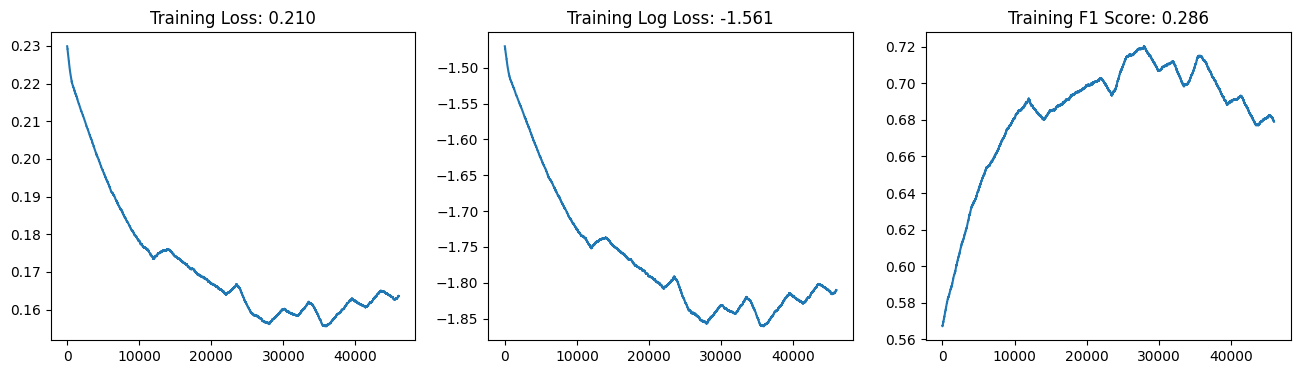

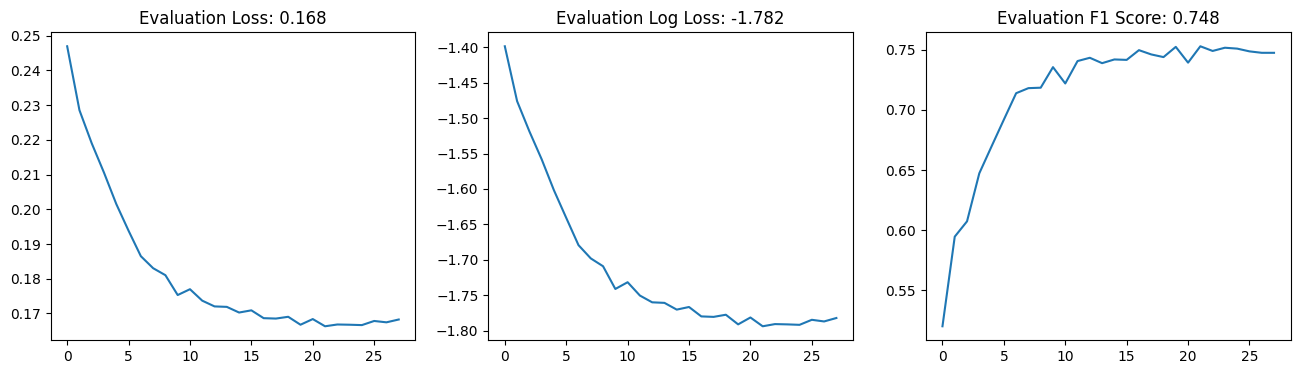

Finished Training


In [24]:
# metrics to track
loss_train, f1_train = [], []
loss_eval, f1_eval = [], []
tracking = {'loss_train': loss_train, 
            'f1_train': f1_train, 
            'loss_eval': loss_eval, 
            'f1_eval': f1_eval}

for epoch in range(EPOCHS):
    print('epoch: ', epoch)
    stop = train_epoch(epoch, tracking, train_loader, eval_loader, model, loss_fn, optimizer, MODEL_NAME, DIFFICULTY, True, VISUALIZATION_STEP, SUPER_BATCH_SIZE, EVAL_INTERVAL)
    if not stop: stop = valid_epoch(epoch, tracking, eval_loader, model, loss_fn, MODEL_NAME, DIFFICULTY, pre = True)
    if stop:
        break
print('Finished Training')
# F1 score does not mean much here, since we are not doing classification
# but it still gives us an idea of how well the model will do later,
# since the output is a value between 0 and 1 and could be interpreted as a probability

### Save

In [ ]:
# Save the pretrained model
#torch.save(model.bert.state_dict(), 'pre_{0}_{1}.pt'.format(MODEL_NAME, DIFFICULTY))

# Training

In [15]:
BATCH_SIZE = 60 # we use a bigger batch size for the final model
SUPER_BATCH_SIZE = 10
EVAL_INTERVAL = 100
LEARNING_RATE = 1e-4
EPOCHS = 40
VISUALIZATION_STEP = 10
DIFFICULTY = 'hard' # 'easy', 'medium', 'hard'
MODEL_NAME, MAX_LENGTH = 'roberta-base', 512
#MODEL_NAME, MAX_LENGTH= "distilbert-base-uncased", 512
# MODEL_NAME, MAX_LENGTH= 'allenai/longformer-base-4096', 1096 #3217

### Model

In [36]:
# model to classify the texts, we use the pretrained bert and add a classication head
class BERTClass(torch.nn.Module):
    def __init__(self, model_name, difficulty='all', load_model=True):
        super(BERTClass, self).__init__()
        # load fine-tuned model and freeze the weights
        self.bert = get_bert(model_name, difficulty, load_model)
        self.bert.requires_grad_(False)
        # add a dropout layer and the classification head
        self.dropout = torch.nn.Dropout(0.4)
        self.linear1 = torch.nn.Linear(768*2, 768*2)
        # In this layer we will introduce cosine similarity and euclidean distance to give more information about the embeddings
        self.linear2 = torch.nn.Linear(768*2 + 2, 1024)
        self.linear3 = torch.nn.Linear(1024, 256)
        self.linear4 = torch.nn.Linear(256, 64)
        self.linear5 = torch.nn.Linear(64, 1)


    def forward(self, input_ids1, input_ids2, attention_mask1, attention_mask2):
        embeddings1 = self.bert(input_ids1, attention_mask=attention_mask1).last_hidden_state[:,0,:]
        embeddings2 = self.bert(input_ids2, attention_mask=attention_mask2).last_hidden_state[:,0,:]
        # We concatenate both embeddings so that the clasiffication head has as much information as posible
        embeddings = torch.cat((embeddings1, embeddings2), dim=1)
        output = self.dropout(embeddings)

        euclidean_distance = torch.nn.functional.pairwise_distance(embeddings1, embeddings2, keepdim=True)/20
        cosine_sim = torch.cosine_similarity(embeddings1, embeddings2, dim=1)
        cosine_sim = torch.abs((cosine_sim + 1)/2 - 1)/2 
        euclidean_distance = torch.clamp(euclidean_distance, max=0.5)

        output = torch.nn.functional.leaky_relu(self.linear1(output))
        output = torch.cat((output, euclidean_distance, cosine_sim.unsqueeze(1)), dim=1)
        output = torch.nn.functional.leaky_relu(self.linear2(output))
        output = torch.nn.functional.leaky_relu(self.linear3(output))
        output = torch.nn.functional.leaky_relu(self.linear4(output))
        output = self.linear5(output)
        return output
    
model = BERTClass(MODEL_NAME)
model.to(device)

Loading model...


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fine-tuned model loaded


BERTClass(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

### Dataset Creation

In [16]:
tokenizer = get_tokenizer(MODEL_NAME)
train_dataset = ADataset(DIFFICULTY, 'train')
valid_dataset = ADataset(DIFFICULTY, 'validation')
info_dataset(train_dataset, tokenizer)
info_dataset(valid_dataset, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, collate_fn=DataCollator(tokenizer, MAX_LENGTH))
eval_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, collate_fn=DataCollator(tokenizer, MAX_LENGTH))

Dataset: train
Number of samples: 40415
Proportion of 1s and 0s: 0.6112334529258938 to 0.38876654707410613
Maximum sequence lenght of dataset: 512


Token indices sequence length is longer than the specified maximum sequence length for this model (732 > 512). Running this sequence through the model will result in indexing errors


Dataset: validation
Number of samples: 4112
Proportion of 1s and 0s: 0.47495136186770426 to 0.5250486381322957
Maximum sequence lenght of dataset: 732


### Loss and Optimizer

In [38]:
loss_fn = torch.nn.BCEWithLogitsLoss()

In [39]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params=params, lr=LEARNING_RATE, weight_decay=0.0001)

### Go

Epoch: 9
Batch: 1/1


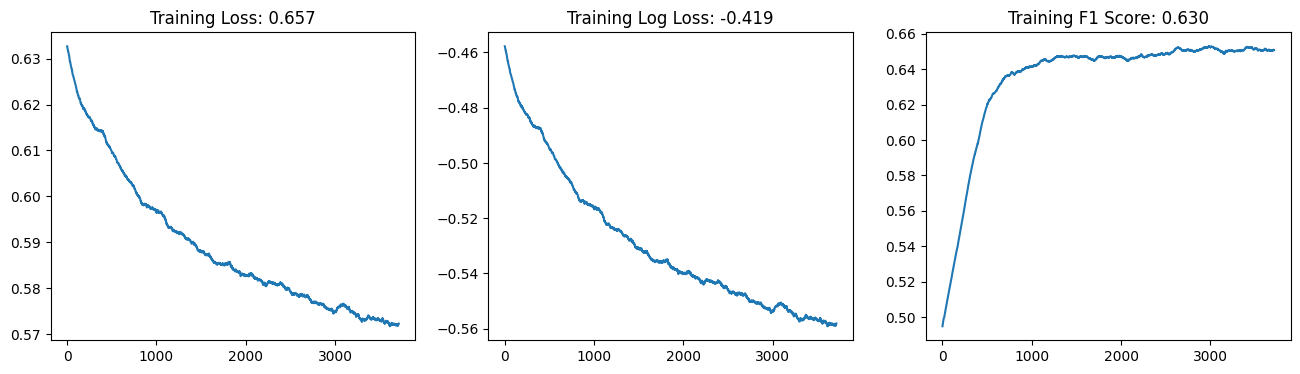

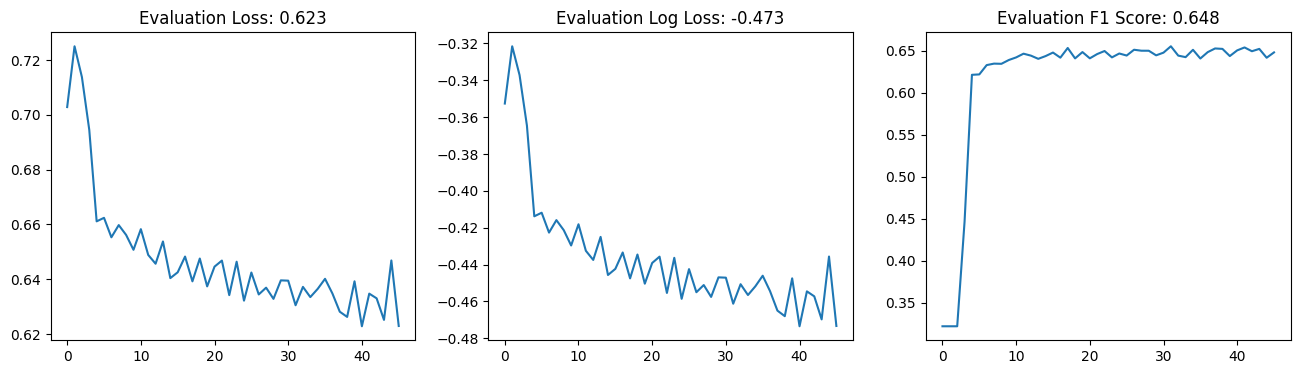

Finished Training


In [50]:
loss_train, f1_train = [], []
loss_eval, f1_eval = [], []
tracking = {'loss_train': loss_train, 
            'f1_train': f1_train, 
            'loss_eval': loss_eval, 
            'f1_eval': f1_eval}

for epoch in range(EPOCHS):
    print('epoch: ', epoch)
    stop = train_epoch(epoch, tracking, train_loader, eval_loader, model, loss_fn, optimizer, MODEL_NAME, DIFFICULTY, False, VISUALIZATION_STEP, SUPER_BATCH_SIZE, EVAL_INTERVAL)
    if not stop: stop = valid_epoch(epoch, tracking, eval_loader, model, loss_fn, MODEL_NAME, DIFFICULTY, pre=False, save=True)
    if stop:
        break
print('Finished Training')

### Save

In [ ]:
# Save the trained model
#torch.save(model.bert.state_dict(), '{0}_{1}.pt'.format(MODEL_NAME, DIFFICULTY))

# Results

In [41]:
BATCH_SIZE = 60
MODEL_NAME, MAX_LENGTH = 'roberta-base', 512

loss = []
f1 = []
for d in ['easy', 'medium', 'hard']:
    # load final model
    model = BERTClass(MODEL_NAME, d, load_model=False)
    state_dict = torch.load('{0}_{1}.pt'.format(MODEL_NAME, d))
    model.load_state_dict(state_dict)
    model.to(device)

    # load the dataset
    tokenizer = get_tokenizer(MODEL_NAME)
    valid_dataset = ADataset(d, 'validation')
    eval_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, collate_fn=DataCollator(tokenizer, MAX_LENGTH))

    # Define loss function
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # evaluate the model
    loss_train, f1_train = [], []
    loss_eval, f1_eval = [], []
    tracking = {'loss_train': loss_train, 
                'f1_train': f1_train, 
                'loss_eval': loss_eval, 
                'f1_eval': f1_eval}
    valid_epoch(0, tracking, eval_loader, model, loss_fn, MODEL_NAME, d, pre=False, save=False)
    loss.append(tracking['loss_eval'][0])
    f1.append(tracking['f1_eval'][0])

# print the results
clear_output(wait=True)
print('Finished Testing')
print('Difficulty easy: Loss: {0} F1: {1}'.format(loss[0], f1[0])) 
print('Difficulty medium: Loss: {0} F1: {1}'.format(loss[1], f1[1]))
print('Difficulty hard: Loss: {0} F1: {1}'.format(loss[2], f1[2]))

Finished Testing
Difficulty easy: Loss: 0.24187743663787842 F1: 0.7925424152086031
Difficulty medium: Loss: 0.4343564808368683 F1: 0.7867627066007614
Difficulty hard: Loss: 0.6239784359931946 F1: 0.6538881164976456


We can appreciate how the F1 score decreases with difficulty. However, it stands out that the performace of the easy and medium datasets are very similar. We believe this is caused by the fact that the easy dataset is poorly balanced, with a ratio of 1s to 0s of 82%, further worsened by the data augmentation to 87%.

We tried fine-tunning bert with each dataset for each specific difficulty and the results where very similar. The one that changed most is the medium difficulty, which gave us worst metrics than when we used all 3 datasets to finetune the bert model. This might be due to the similarities that it has with both easy and hard datasets.

When compared to the base model of roberta without fine-tuning, the results are much improved. It was the first thing we tried: training a classification head on top of the base roberta model. It did not work, never reaching an F1 score above 0.5 in any of the different difficulties.

When compared to the best performing models up to date (not sure how fair the comparison is, given we might not be using the same F1 averaging method):
- Easy: some reach up to 0.98, which beats us by a big margin.
- Medium: the best is 0.84, very close to ours.
- Hard: the best are around 0.8, again, much better than us.

This is not surprising, as this researchers have access to much more computational resources than us.